In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,input_temp,temp_total04,buoyancy,diffusivity,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp
0,1,20.067094,700.346566,-100.232536,22.533627,695.446647,0.248168,1.054814,0.002187,36000000.0,13.110569,13.501710,0.000533,0.000010,13.501710,155,15,13.501710,13.501710,16.409
1,2,20.067094,700.346566,-100.232536,22.533627,695.446647,0.248168,1.054814,0.002187,36000000.0,11.806688,11.907665,0.000533,0.000016,11.907665,155,15,11.907665,11.907665,16.480
2,3,20.067094,700.346566,-100.232536,22.533627,695.446647,0.248168,1.054814,0.002187,36000000.0,11.306141,11.368285,0.000262,0.000021,11.368285,155,15,11.368285,11.368285,16.130
3,4,20.067094,700.346566,-100.232536,22.533627,695.446647,0.248168,1.054814,0.002187,36000000.0,11.048210,11.092567,0.000150,0.000027,11.092567,155,15,11.092567,11.092567,15.827
4,5,20.067094,700.346566,-100.232536,22.533627,695.446647,0.248168,1.054814,0.002187,36000000.0,10.896431,10.928626,0.000100,0.000032,10.928626,155,15,10.928626,10.928626,16.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53170,21,8.158799,715.639026,-243.644276,-72.050019,0.000000,1.416667,1.672067,0.004574,36000000.0,8.682822,8.683785,0.000757,0.000013,8.683785,244,5,8.683785,8.683785,12.294
53171,22,8.158799,715.639026,-243.644276,-72.050019,0.000000,1.416667,1.672067,0.004574,36000000.0,7.425032,7.425783,0.000528,0.000016,7.425783,244,5,7.425783,7.425783,12.294
53172,23,8.158799,715.639026,-243.644276,-72.050019,0.000000,1.416667,1.672067,0.004574,36000000.0,6.179781,6.180297,0.000300,0.000020,6.180297,244,5,6.180297,6.180297,12.294
53173,24,8.158799,715.639026,-243.644276,-72.050019,0.000000,1.416667,1.672067,0.004574,36000000.0,4.940607,4.940868,0.000065,0.000037,4.940868,244,5,4.940868,4.940868,12.294


In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 2127
Number of training points: 31900


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Loading Models

## Heat Diffusion Model

In [7]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'input_temp']
m1_output_columns = ['diffusivity', 'temp_diff01']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./saved_models/heat_diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [8]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day', 'temp_diff01']
m2_output_columns = ['temp_mix02']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [9]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix02']
m3_output_columns = ['temp_conv03']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [10]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_conv03']
m4_output_columns = ['temp_total04']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [11]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [12]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [13]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [14]:
print(train_data.shape)
print(test_data.shape)

(31900, 20)
(21275, 20)


In [15]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [16]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [17]:
def get_rollout_predictions(heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 4))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        

        m1_input = x[:, m1_input_column_ix]
            
        #model 1
        m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        m1_pred_temp = m1_pred[:,1:2]
            
        if plot:
            m1_y_true = x[:, m1_output_column_ix[1]] * torch.tensor(train_std[m1_output_column_ix[1]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[1]]).to(device)
            m1_y_pred = m1_pred_temp * torch.tensor(train_std[m1_output_column_ix[1]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[1]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
#                 print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred_temp], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        if plot:
            m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            rmse_models[ix, 1] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
#                 print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 2] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
#                 print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 3] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
#                 print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean

        pred = m4_pred * std + mean
        
        y_.append(y_true)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
#     if plot:
#         rmse_models = rmse_models.mean(axis=0)
#         plt.figure(figsize=(12,8))
#         plt.plot(rmse_models[:, 0], label="RMSE after Heat-Diffusion Model")
#         plt.plot(rmse_models[:, 1], label="RMSE after Mixing Model")
#         plt.plot(rmse_models[:, 2], label="RMSE after Convection Model")
#         plt.plot(rmse_models[:, 3], label="RMSE after Ice Model")
#         plt.legend(loc="upper left", fontsize=12)
#         plt.xlabel("Depth", fontsize=12)
#         plt.ylabel("RMSE", fontsize=12)
#         plt.grid("on", alpha=0.5)
#         plt.show()
    
    return pred_, y_, rmse_models


In [18]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [19]:
train_y_pred, train_y_true, train_rmse_models = get_rollout_predictions(heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)
train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE: {train_rmse}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

Train RMSE: 0.10291177779436111
Train L2 Error: 0.007227682508528233
The RMSEs after each modelling stage: [0.08091957 0.09639877 0.09610429 0.09595425]


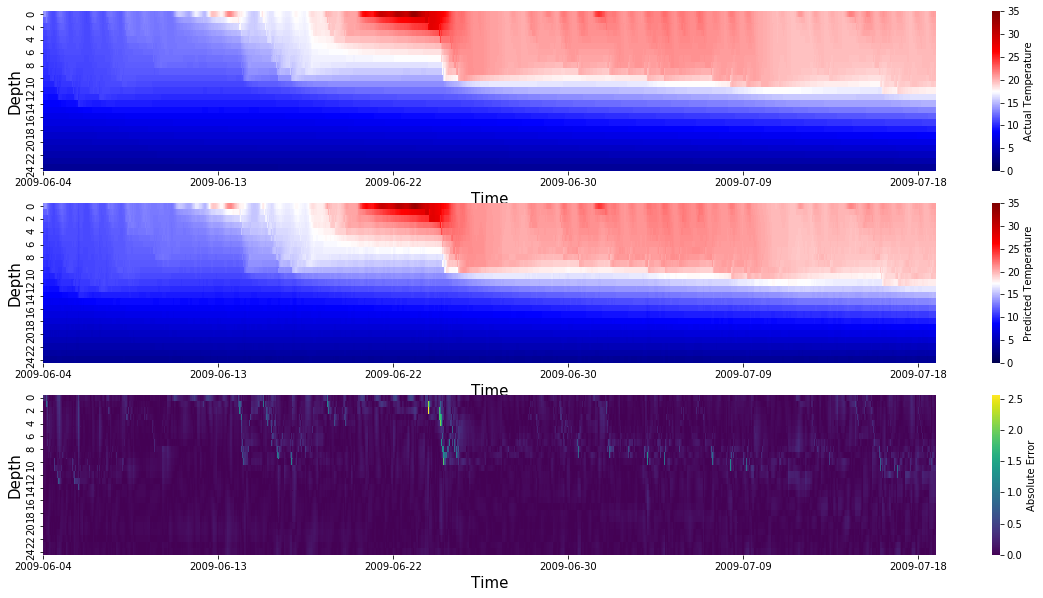

In [20]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

## Test Results

In [21]:
test_y_pred, test_y_true, test_rmse_models = get_rollout_predictions(heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)
test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"test RMSE: {test_rmse}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

test RMSE: 0.29926931858062744
test L2 Error: 0.01828470639884472
The RMSEs after each modelling stage: [0.27206151 0.27283672 0.28075058 0.28045667]


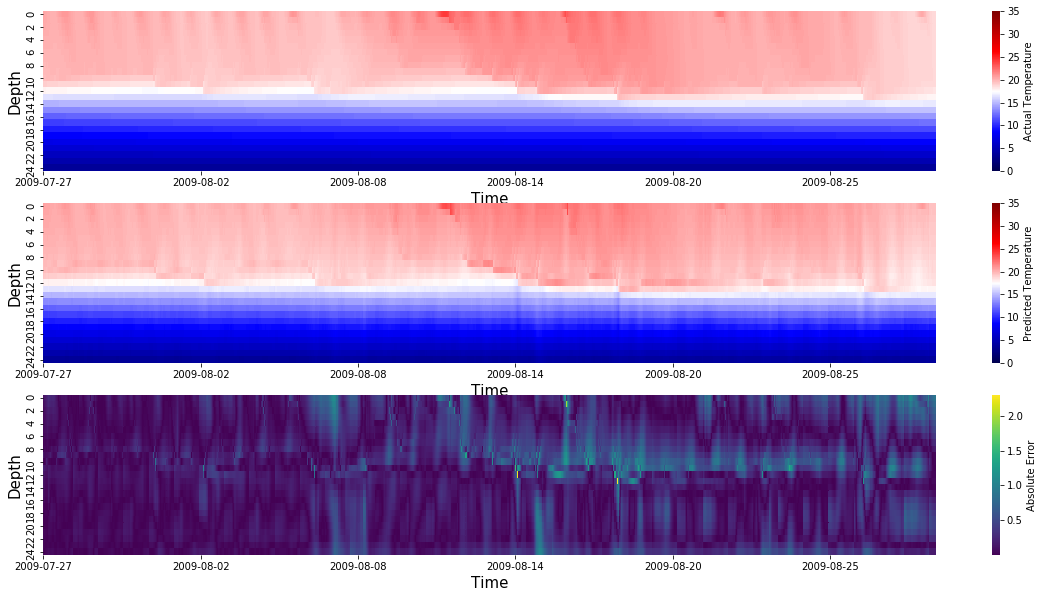

In [22]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [23]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0817324900459821, Train L2 Error: 0.005737879831358262
Test RMSE: 0.28902133453297296, Train L2 Error: 0.01762312677380483


## Mixing Model

In [24]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.06913960640909658, Train L2 Error: 0.004853585871637515
Test RMSE: 0.1354986655051394, Train L2 Error: 0.00826164366548435


## Convection Model

In [25]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0099779300173876, Train L2 Error: 0.0007004577548893045
Test RMSE: 0.05274486667913477, Train L2 Error: 0.0032160462950799893


## Ice Model

In [26]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.0022876743880760205, Train L2 Error: 0.0001605963624716858
Test RMSE: 0.06627033751756038, Train L2 Error: 0.0040407434289972625


# Finetuning

In [27]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heat_diff_model.parameters()) + list(mixing_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [28]:
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
        m1_input = x[:, m1_input_column_ix]


        #model 1
        m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        m1_pred_temp = m1_pred[:,1:2]
            
        loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred_temp], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        loss_m2 = criterion(m2_pred, x[:, m2_output_column_ix])

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)

        loss_m4 = criterion(m4_pred, x[:, m4_output_column_ix])
        
        loss = (loss_m1 + loss_m2 + loss_m3 + loss_m4)
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m2 += loss_m2.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m2 = loss_epoch_m2/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m2.append(loss_epoch_m2)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m1: {LOSS_m1[-1]}, Loss m2: {LOSS_m2[-1]}, Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/500 [00:00<02:47,  2.97it/s]

Epoch : 0, Train_loss: 0.0011065779117416241, Loss m1: 0.00019642285394638748, Loss m2: 0.0003026169276836299, Loss m3: 0.00030141828347041155, Loss m4: 0.00030611984357165056


 10%|█         | 51/500 [00:19<02:52,  2.60it/s]

Epoch : 50, Train_loss: 0.0009046024970302824, Loss m1: 0.00016061111773524317, Loss m2: 0.0002500197039125851, Loss m3: 0.00024722911609842413, Loss m4: 0.00024674256360412983


 20%|██        | 101/500 [00:39<02:31,  2.63it/s]

Epoch : 100, Train_loss: 0.0008571360622227076, Loss m1: 0.0001506604460246308, Loss m2: 0.0002376196995328428, Loss m3: 0.00023472891336950852, Loss m4: 0.00023412699738400988


 30%|███       | 151/500 [00:58<02:12,  2.64it/s]

Epoch : 150, Train_loss: 0.0008231102292484138, Loss m1: 0.00014300272607670195, Loss m2: 0.00022841557677111268, Loss m3: 0.00022587729654333089, Loss m4: 0.00022581463940696267


 40%|████      | 201/500 [01:16<01:48,  2.77it/s]

Epoch : 200, Train_loss: 0.0007938064354675589, Loss m1: 0.00013677095046205068, Loss m2: 0.0002207914333212102, Loss m3: 0.0002182308160172397, Loss m4: 0.00021801323566705832


 50%|█████     | 251/500 [01:35<01:30,  2.75it/s]

Epoch : 250, Train_loss: 0.0007711017447036284, Loss m1: 0.00013140016392299003, Loss m2: 0.0002145269942275263, Loss m3: 0.0002124256391198287, Loss m4: 0.0002127489440226782


 60%|██████    | 301/500 [01:53<01:13,  2.71it/s]

Epoch : 300, Train_loss: 0.0007511962317039433, Loss m1: 0.00012667219209561154, Loss m2: 0.00020905453425257292, Loss m3: 0.00020734958786761126, Loss m4: 0.00020811991362279514


 70%|███████   | 351/500 [02:12<00:52,  2.86it/s]

Epoch : 350, Train_loss: 0.0007328085685003316, Loss m1: 0.00012242767911629926, Loss m2: 0.00020411841023815214, Loss m3: 0.00020263781414087134, Loss m4: 0.00020362467193990597


 80%|████████  | 401/500 [02:30<00:35,  2.77it/s]

Epoch : 400, Train_loss: 0.0007160851300795912, Loss m1: 0.00011858472703352163, Loss m2: 0.00019966398451742862, Loss m3: 0.000198351679841835, Loss m4: 0.00019948474744069244


 90%|█████████ | 451/500 [02:48<00:17,  2.72it/s]

Epoch : 450, Train_loss: 0.0007009179007582134, Loss m1: 0.00011508397881243582, Loss m2: 0.00019562924910587753, Loss m3: 0.00019446950648216443, Loss m4: 0.00019573516817672498


100%|██████████| 500/500 [03:06<00:00,  2.68it/s]


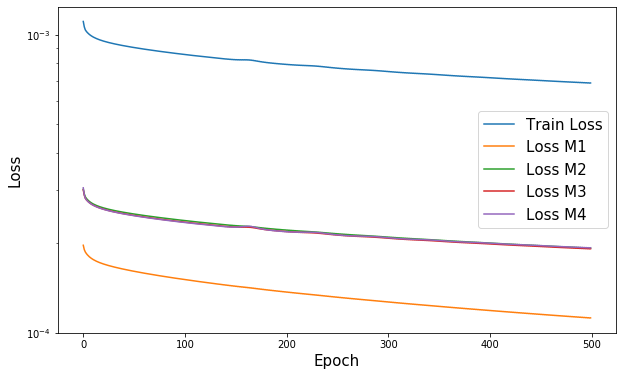

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m1, label = "Loss M1")
plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [30]:
train_y_pred, train_y_true, train_rmse_models = get_rollout_predictions(heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)
train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE: {train_rmse}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

Train RMSE: 0.08416996896266937
Train L2 Error: 0.005904055200517178
The RMSEs after each modelling stage: [0.06233909 0.07555824 0.07553649 0.07627721]


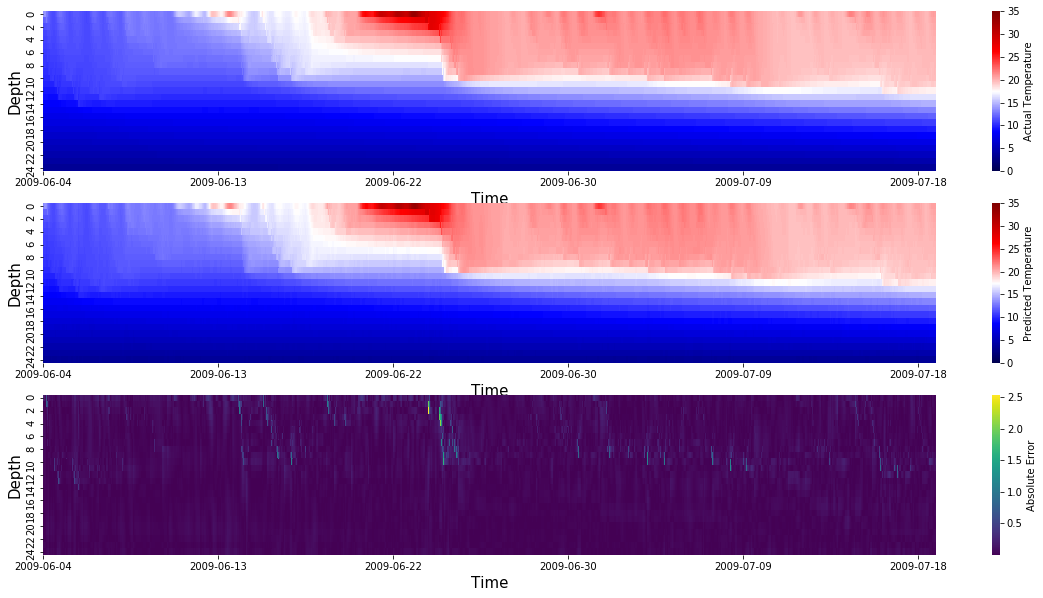

In [31]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [32]:
test_y_pred, test_y_true, test_rmse_models = get_rollout_predictions(heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)
test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"test RMSE: {test_rmse}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

test RMSE: 0.32487574219703674
test L2 Error: 0.020006300881505013
The RMSEs after each modelling stage: [0.26417086 0.27257758 0.30120078 0.29727537]


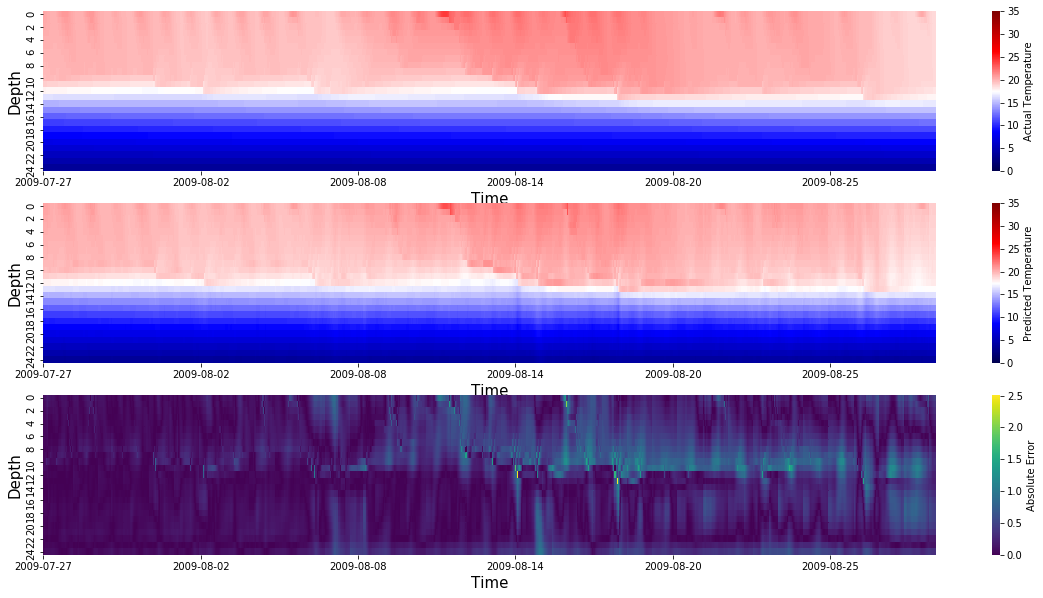

In [33]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [34]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.06315006644850951, Train L2 Error: 0.004433334802597874
Test RMSE: 0.28492917377249327, Train L2 Error: 0.017373606550748433


## Mixing Model

In [35]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.06762048075438823, Train L2 Error: 0.004746943569231169
Test RMSE: 0.1171317516534875, Train L2 Error: 0.007141773614282695


## Convection Model

In [36]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.009577713903426937, Train L2 Error: 0.0006723623002041248
Test RMSE: 0.07730333090942722, Train L2 Error: 0.004713465150665617


## Ice Model

In [37]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.005099550141692936, Train L2 Error: 0.0003579920321119758
Test RMSE: 0.043502539863429016, Train L2 Error: 0.002652508025196993


# Compute Model Similarity after Finetuning

In [38]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [39]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9995736479759216
L2 Norm: 0.3441256284713745


In [40]:
mixing_model_init = MLP(m2_layers, activation="gelu")
mixing_model_init.load_state_dict(m2_checkpoint)
mixing_model_init = mixing_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(mixing_model_init, mixing_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9999570846557617
L2 Norm: 0.06498273462057114


In [41]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9999690055847168
L2 Norm: 0.05517445504665375


In [42]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9999879002571106
L2 Norm: 0.03311529383063316


In [43]:
import torch

In [44]:
t= torch.randn(10, 1, 224, 224)

In [47]:
torch.gradient(t[:,0,:,:], dim=2, edge_order=1)[0].shape

torch.Size([10, 224, 224])